In [1]:
import os
os.chdir("..")
from src.SparkEnv import sparkSess
import pyspark.sql.functions as F
from pyspark.sql import DataFrameStatFunctions as statFunc
import pandas as pd

Successfully imported Spark Context and Spark Configuration


In [2]:
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, FloatType
from pyspark.sql.functions import UserDefinedFunction, udf, struct
from pyspark.sql.functions import col
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [3]:
def title_ticks_ecc(title, xlabel, ylabel, new_fig= True , figsize= (10,6), title_size=18):
    if new_fig== True:
        plt.figure(figsize=figsize)
        
    plt.title(title, color= 'xkcd:pale red', fontsize= title_size, pad= 13, fontweight= 'bold')
    plt.xlabel(xlabel, color='xkcd:pale red', fontsize= 14, fontweight= 'bold')
    plt.ylabel(ylabel, color= 'xkcd:pale red', fontsize= 14, fontweight= 'bold')
    plt.xticks(fontsize=12, color= 'xkcd:cadet blue')
    plt.yticks(fontsize=12, color= 'xkcd:cadet blue')

### File Info

We copy these files from S3 into HDFS, we have the following files

- `feature_data/`
   Contains feature value mappings, to be converted into sparse array
- `featureIndex.csv`
   Contains feature_indices + descriptions
- `user_requests_10mil/`
   Contains ALL 10 Million RFI Ids (important to note that some of these will not be in feature_data, as those records have no data)
- `md5_match_data.csv`
   Contains md5 -> RFI mappings from datacloud team


In [4]:
pre = "hdfs:///input"

In [5]:
!hadoop fs -ls $pre/

Found 4 items
-rw-r--r--   1 hadoop hadoop    6260261 2020-07-28 11:17 hdfs:///input/featureIndex.csv
drwxr-xr-x   - hadoop hadoop          0 2020-07-28 11:16 hdfs:///input/feature_data
-rw-r--r--   1 hadoop hadoop 1054158304 2020-07-28 11:17 hdfs:///input/md5_match_data.csv
drwxr-xr-x   - hadoop hadoop          0 2020-07-28 11:17 hdfs:///input/user_requests_10mil


### Loading dataframe of ALL RFI IDs

File contains
- RFI ID
- Request ID (we do not need this column)

In [6]:
all_rfi_DF = \
  sparkSess.read.csv(f"{pre}/user_requests_10mil", sep="\t") \
           .toDF(*["RFI", "Request ID"]) \
           .select("RFI")

all_rfi_DF.printSchema()

root
 |-- RFI: string (nullable = true)



### Loading dataframe of MD5 -> RFI Mappings

File contains
- RFI ID
- Request ID (we do not need this column)

In [7]:
md5_rfi_mappings_DF = \
  sparkSess.read.csv(f"{pre}/md5_match_data.csv/") \
           .toDF(*["RFI", "MD5"])
    
md5_rfi_mappings_DF.printSchema()

root
 |-- RFI: string (nullable = true)
 |-- MD5: string (nullable = true)



### Joining Records 

In [8]:
joined_records_DF = \
  all_rfi_DF.join(md5_rfi_mappings_DF, on="RFI", how="inner")

joined_records_DF.limit(10) \
                 .show()

+-------------------+--------------------+
|                RFI|                 MD5|
+-------------------+--------------------+
|1001558335910283967|a96b6d100ba9de09e...|
|1001558335910283967|bf3558b830afd37f4...|
|1001558335910283967|30df85ec60751d05b...|
|1001558335910283967|12842a3ce3e3ed472...|
|1001558335916624266|780153f39b9c3cc34...|
|1001558335916624266|a82a908be803a615f...|
|1001558335916624266|1e9b88cfda2c212ef...|
|1001558335916624266|20348bee6be5afa00...|
|1001558335916624266|3d9d18dcc821e481d...|
|1001558335916624266|abe024ad5858bbee6...|
+-------------------+--------------------+



### Calculating Match Rate (ALL RFI)
- Look at distinct RFI, Distinct MD5s and get approx match rate

In [9]:
summary_all_RFI_DF = \
  joined_records_DF.agg(F.countDistinct("RFI").alias("Unique RFIs ALL")) \
                   .withColumn("Match Rate - ALL", F.col("Unique RFIs ALL") / F.lit(10e6)) \
                   .toPandas()

summary_all_RFI_DF    

,Unique RFIs ALL,Match Rate - ALL
0,2495277,0.249528


### Calculating Match Rate (RFI with DSP Data)
- Now we will look at percentage of RFIs With DSP DATA


In [10]:
## Small trick to give column names

rfi_in_feature_data_DF = \
  sparkSess.read.csv(f"{pre}/feature_data/") \
           .toDF(*["RFI", "FeatureData", "FeatureValue"]) \
           .dropDuplicates() 

total_count = rfi_in_feature_data_DF.count()
print("Total Number of Unique MD5s with DSP Data Available", total_count)


rfi_with_md5 = \
          rfi_in_feature_data_DF.join(md5_rfi_mappings_DF, on='RFI', how='inner')


summary_RFI_WITH_DATA_DF= rfi_with_md5.agg(F.countDistinct("RFI").alias("Unique RFIs W/ DSP Data")) \
                        .withColumn("Match Rate - W/ DSP Data", F.col("Unique RFIs W/ DSP Data")/total_count)  \
                        .toPandas()

summary_RFI_WITH_DATA_DF

# pd.concat([summary_RFI_WITH_DATA_DF, summary_all_RFI_DF], axis='columns').to_markdown()

Total Number of Unique MD5s with DSP Data Available 609954281


,Unique RFIs W/ DSP Data,Match Rate - W/ DSP Data
0,2471549,0.004052


### Looking at Distribution of Mappings of RFI to MD5: 

- Looks like most RFIs have SEVERAL md5s mapped to them

In [11]:
num_MD5_DF = \
  joined_records_DF.groupby("RFI") \
                   .agg(F.countDistinct("MD5").alias("Num MD5 Per RFI"))

       
num_MD5_DF.approxQuantile("Num MD5 Per RFI", [.25,.5,.75], 0)

[5.0, 10.0, 10.0]

### Looking at Distribution of Mappings from MD5 to RFI

- When looking at the reverse, we see that most MD5s only have ONE RFI mapped to them.

In [ ]:
num_RFI_DF = \
  joined_records_DF.groupby("MD5") \
                   .agg(F.countDistinct("RFI").alias("Num RFI Per MD5")) \

#added .9 to see if ensure records have multiple
num_RFI_DF.approxQuantile("Num RFI Per MD5", [.25,.5,.75],0)

### Frequency-based analysis: checking how many features would be removed at varying threshold

In [50]:
## NO NEED, column names already assigned


# mapping_cols= {  
#               '_c0': 'RFI',
#              '_c1': 'FeatureData',
#              '_c2': 'FeatureValue'}

# for col_name in mapping_cols:
#       rfi_with_md5= rfi_with_md5.withColumnRenamed(col_name, mapping_cols[col_name])

In [ ]:
## Dropping duplicates due to the join (THIS IS WAY TOO SLOW!!)

# relevant_rfi_set = set(list(rfi_with_md5.select('RFI').distinct().toPandas()['RFI'].values))
# rfi_with_md5 = rfi_in_feature_data_DF.filter(col('RFI').isin(relevant_rfi_set))

In [47]:
##### Other approach, much faster

ONLY_RFI_WITH_MD5 = False  # --> FOR NOW SKIPING THIS STEP: WE WORK ON ALL RFIs 


if ONLY_RFI_WITH_MD5 is True:


    rfi_in_feature_data_DF.createOrReplaceTempView("all_rfi")
    rfi_with_md5.createOrReplaceTempView("relevant_rfi")


    ## Taking only RFIs for which exists at least a MD5 
    rfi_with_md5_final = sparkSess.sql("SELECT * \
                                        FROM all_rfi AS A    \
                                        WHERE A.RFI IN (SELECT RFI from relevant_rfi)")
    
    ### I must have less data now, since I removed the RFI without MD5
    assert(rfi_in_feature_data_DF.count() > rfi_with_md5_final.count())


else:
    rfi_with_md5_final= rfi_in_feature_data_DF


    
rfi_with_md5_final.count()

609954281

In [48]:
rfi_with_md5_final.persist()    # to save it in memory, avoiding

rfi_with_md5_final.show()

+-------------------+-----------+------------+
|                RFI|FeatureData|FeatureValue|
+-------------------+-----------+------------+
|2339690379464055637|      73463|         1.0|
|2339690379464055637|       4106|         1.0|
| 785667041688333971|      62606|         1.0|
| 785667041688333971|      10198|         1.0|
|                 -3|      41084|         1.0|
|1604759211138415998|      84457|         1.0|
|1604759211138415998|       7183|         1.0|
|1604759211138415998|      66815|         1.0|
|2339971853560503937|      88051|         1.0|
|2827015835580892361|      86246|         1.0|
| 781163441030308167|      23079|         1.0|
|1991787305125980208|       4355|         1.0|
|1648950788504470285|      39643|         1.0|
| 959337092075575881|      81459|         1.0|
|8508968658018156499|      92286|         1.0|
| 767652642365707799|      18613|         1.0|
|2295336441816022299|      39643|         1.0|
|1040683385300536358|      86913|         1.0|
|104068338530

In [49]:
print('Number of unique features for the 7.5 M relevant RFIs is: ', rfi_with_md5_final.select('FeatureData').distinct().count())

Number of unique features for the 2.5 M relevant RFIs is:  94113


In [50]:
### QUALITY CHECK: Max redoundancy should be 1: each RFI does not have duplicate features

rfi_with_md5_final.groupBy(['RFI', 'FeatureData']).agg(F.count('FeatureValue').alias('Feat_Redoundancy')) \
                                .orderBy(col('Feat_Redoundancy').desc()).show() 

+-------------------+-----------+----------------+
|                RFI|FeatureData|Feat_Redoundancy|
+-------------------+-----------+----------------+
|                 -3|      67442|             637|
|                 -3|      12839|             637|
|                 -3|      69370|             637|
|                 -3|       1199|             574|
|                 -3|      69540|             574|
|                 -3|       8250|             574|
|                 -3|       5333|             461|
|                 -3|      52192|             461|
|                 -3|       3400|             461|
|                 -3|      11632|             405|
|                 -3|      39536|             405|
|                 -3|      45652|             405|
|                 -3|      41931|             229|
|                 -3|      73844|             229|
|                 -3|       4261|             229|
|                 -3|      36693|             181|
|                 -3|      1868

In [51]:
final_n_RFI = rfi_with_md5_final.select('RFI').distinct().count()
final_n_RFI       ## Correct, ~2.5M as before

7830889

In [52]:
# rfi_in_feature_data.filter(col('RFI')!= -3).groupBy(['RFI', 'FeatureData']).agg(F.count('FeatureValue').alias('Feat_Redoundancy')) \
#                                 .orderBy(col('Feat_Redoundancy').desc()).show()

In [53]:
feat_frequency= rfi_with_md5_final.groupBy("FeatureData")   \
    .agg(F.count('RFI').alias('Feature_frequency'), F.mean('FeatureValue').alias('AVG_value'), F.stddev('FeatureValue').alias('STD_value') ) \
    .orderBy(col('Feature_frequency').desc())

feat_frequency.show(10)

+-----------+-----------------+---------+--------------------+
|FeatureData|Feature_frequency|AVG_value|           STD_value|
+-----------+-----------------+---------+--------------------+
|      76429|          7830889|      1.0|1.085105594037066...|
|      90340|          7830889|      1.0|                 0.0|
|      26836|          7830889|      1.0|                 0.0|
|      41969|          7724763|      1.0|                 0.0|
|      15841|          7619540|      1.0|                 0.0|
|      82561|          7343313|      1.0|                 0.0|
|      86209|          7343312|      1.0|                 0.0|
|      32531|          6426512|      1.0|                 0.0|
|      29264|          6173406|      1.0|1.085099562922718...|
|      43734|          6019379|      1.0|                 0.0|
+-----------+-----------------+---------+--------------------+
only showing top 10 rows



In [54]:
feat_frequency= feat_frequency.withColumn('Feature_freq_norm', feat_frequency['Feature_frequency']*100/ final_n_RFI) 
feat_frequency.show(10)

+-----------+-----------------+---------+--------------------+-----------------+
|FeatureData|Feature_frequency|AVG_value|           STD_value|Feature_freq_norm|
+-----------+-----------------+---------+--------------------+-----------------+
|      90340|          7830889|      1.0|                 0.0|            100.0|
|      26836|          7830889|      1.0|                 0.0|            100.0|
|      76429|          7830889|      1.0|                 0.0|            100.0|
|      41969|          7724763|      1.0|                 0.0|98.64477711279014|
|      15841|          7619540|      1.0|7.167348744863059...|97.30108548339786|
|      82561|          7343313|      1.0|                 0.0|93.77368265595388|
|      86209|          7343312|      1.0|                 0.0|93.77366988601166|
|      32531|          6426512|      1.0|7.172720195370208...|82.06618686588457|
|      29264|          6173406|      1.0|                 0.0|78.83403787232842|
|      43734|          60193

In [55]:
relevant_percentiles = list(np.arange(0.1, 0.96, 0.05))


freq_thresholds_perc = feat_frequency.approxQuantile("Feature_freq_norm", relevant_percentiles, 0)

rounded_thresholds = [round(tr, 4) for tr in freq_thresholds_perc]

#str_percentiles = [str(round(100* perc,2)) + '%'  for perc in relevant_percentiles]

dict_freq_thresholds= dict(zip(rounded_thresholds, [round(100*perc, 1) for perc in relevant_percentiles] ))
dict_freq_thresholds

{0.0015: 10.0,
 0.0017: 15.0,
 0.0019: 20.0,
 0.0022: 25.0,
 0.0025: 30.0,
 0.0029: 35.0,
 0.0034: 40.0,
 0.004: 45.0,
 0.0048: 50.0,
 0.0057: 55.0,
 0.0071: 60.0,
 0.0089: 65.0,
 0.0115: 70.0,
 0.0153: 75.0,
 0.0212: 80.0,
 0.0325: 85.0,
 0.0557: 90.0,
 0.1284: 95.0}

In [56]:
relevant_percentiles = list(np.arange(0.1, 0.96, 0.05))


freq_thresholds_abs = feat_frequency.approxQuantile("Feature_frequency", relevant_percentiles, 0)

rounded_thresholds_abs = [round(tr, 4) for tr in freq_thresholds_abs]

#str_percentiles = [str(round(100* perc,2)) + '%'  for perc in relevant_percentiles]

dict_freq_thresholds_abs= dict(zip(rounded_thresholds_abs, [round(100*perc, 1) for perc in relevant_percentiles] ))
dict_freq_thresholds_abs

{116.0: 10.0,
 131.0: 15.0,
 149.0: 20.0,
 171.0: 25.0,
 196.0: 30.0,
 226.0: 35.0,
 265.0: 40.0,
 315.0: 45.0,
 374.0: 50.0,
 450.0: 55.0,
 557.0: 60.0,
 700.0: 65.0,
 899.0: 70.0,
 1199.0: 75.0,
 1658.0: 80.0,
 2542.0: 85.0,
 4361.0: 90.0,
 10054.0: 95.0}

In [57]:
pwd

'/home/hadoop/dsp-non-addressable-model'

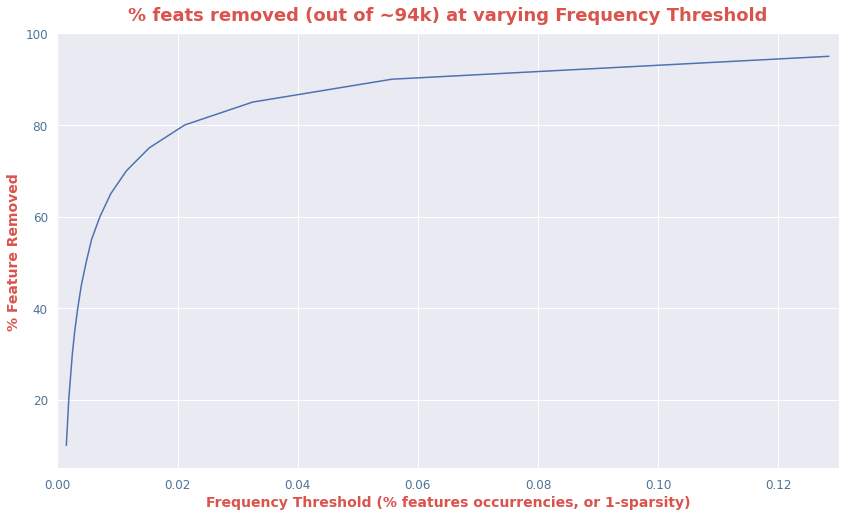

In [70]:
title_ticks_ecc('% feats removed (out of ~94k) at varying Frequency Threshold', 
                            'Frequency Threshold (% features occurrencies, or 1-sparsity)', '% Feature Removed', 
                              figsize= (14,8))

plt.ylim(5, 100)
plt.xlim(0, 0.13)

pd.Series(dict_freq_thresholds).plot()

plt.savefig('/home/hadoop/dsp-non-addressable-model/outputs/Frequency_based_plot.PNG', bbox_inches='tight')

## Based on the plot, I choose 0.15% as percentage frequency threshold, corresponding to ~4000 absolute frequency

In [71]:
choosen_thresh_norm= 0.15


preliminary_selected_feats= feat_frequency.where(col('Feature_freq_norm') > choosen_thresh_norm).toPandas() #small size
preliminary_selected_feats.shape

(4077, 5)

In [72]:
## Deleting those having super high frequncy and 0 standard deviation (it means they are constant, 
## if for instance they have 100% frequency and std_dev=0 )


to_drop= list((  preliminary_selected_feats[(    
                        preliminary_selected_feats['Feature_freq_norm'] > 99.0) & (
                        preliminary_selected_feats['STD_value'] < 0.0001)
                        ]).index)

preliminary_selected_feats.drop(to_drop, inplace= True)


print('Shape of DF with final features: '.format(preliminary_selected_feats.shape))
preliminary_selected_feats.head()

Shape of DF with final features: 


,FeatureData,Feature_frequency,AVG_value,STD_value,Feature_freq_norm
3,41969,7724763,1.0,0.0,98.644777
4,15841,7619540,1.0,0.0,97.301085
5,82561,7343313,1.0,0.0,93.773683
6,86209,7343312,1.0,0.0,93.773670
7,32531,6426512,1.0,0.0,82.066187


In [73]:
preliminary_selected_feats.describe()

,Feature_frequency,AVG_value,STD_value,Feature_freq_norm
count,4.074000e+03,4074.000000,4074.000000,4074.000000
mean,1.208571e+05,0.997774,0.001256,1.543338
std,5.052714e+05,0.033702,0.018871,6.452287
min,1.174900e+04,0.342468,0.000000,0.150034
25%,1.631600e+04,1.000000,0.000000,0.208354
50%,2.530300e+04,1.000000,0.000000,0.323118
75%,5.164125e+04,1.000000,0.000000,0.659456
max,7.724763e+06,1.000000,0.295820,98.644777


In [74]:
### Exporting as csv
preliminary_selected_feats.to_csv(
                '/home/hadoop/dsp-non-addressable-model/outputs/top_4000_feats.csv', index= False)

#### Copying top features selected to S3

In [1]:
!ls -la '/home/hadoop/dsp-non-addressable-model/outputs'

total 123516
drwxrwxr-x 2 hadoop hadoop      4096 Jul 31 13:10 .
drwxrwxr-x 7 hadoop hadoop      4096 Jul 31 13:33 ..
-rw-rw-r-- 1 hadoop hadoop 126267164 Jul 31 14:25 final_1_1_mapping.csv
-rw-rw-r-- 1 hadoop hadoop     35878 Jul 31 13:10 Frequency_based_plot.PNG
-rw-rw-r-- 1 hadoop hadoop    166191 Jul 31 13:10 top_4000_feats.csv


In [2]:
!aws s3 cp /home/hadoop/dsp-non-addressable-model/outputs/top_4000_feats.csv s3://gdsa-prague/dsp_LAL/outputs/

upload: ../outputs/top_4000_feats.csv to s3://gdsa-prague/dsp_LAL/outputs/top_4000_feats.csv


In [3]:
!rm /home/hadoop/dsp-non-addressable-model/outputs/top_4000_feats.csv